In [2]:
# load libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score, balanced_accuracy_score

# Introduction
Amid, the Covid-19 worldwide pandemic, there is much controversy over the amount of response, drastic or otherwise, is warranted during this time. Some of the major points of discussion thrown around are the death rate and the risk factors. Namely, age, race, and underlying medical conditions. With this analysis, we will build a model to predict whether somebody will die of covid-19 given some basic patient level demographic data. We'll also determine some of the major risk factors associated with covid-19 mortality.

# Exploratory Data Analysis

The data comes from the official CDC API (Hence it is all from the USA). It was created on May 20, 2020 and it is updated on a montly basis. The temporal span of the data is from Jan 1, 2020 to November 19, 2020. There are over 8 million rows in the dataset. We will only sample a few hundred thousand rows of those for our analysis. There are 11 columns included:

Target: 
    
1. `death_yn` - did the individual die?
        
Features:
    
1.	`cdc_report_dt` – date case was reported to CDC
2.	`pos_spec_dt` – date of first pos specimen collection
3.	`onset_dt` – symptom onset date, if symptomatic
4.	`current_status` – Laboratory-confirmed case or probable case?
5.	`sex`
6.	`age_group`
7.	`race_and_ethnicity`
8.	`hosp_yn` – admitted to hospital or not
9.	`icu_yn` – admitted to icu or not
10.	`medcond_yn` – did they have an underlying comorbidity or disease?

C:\Users\barne\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
# covid = pd.read_csv("covid_data_all.csv")

In [ ]:
url = "https://data.cdc.gov/resource/vbim-akqf.csv?$limit=8000000"
# this takes a while to read the results, careful re-running it
covid = pd.read_csv(url)


Here we separate by people who died and survived, and then sample 150000 from each group. We then sample 50000 irrespective of whether they died or not.

Note: Because there are far more people who survive covid-19, we will be oversampling deaths from the data. This will help our model train better. However, when we test the model, we will predict on random raw data.

In [4]:
surv = covid[covid.death_yn == "No"]
died = covid[covid.death_yn == "Yes"]
surv_samp = surv.sample(150000)
died_samp = died.sample(150000)
cov_random = covid[covid.death_yn.isin(['Yes', 'No'])].sample(50000)

Next we concatenate the data all together and label the rows by the sampling method

In [5]:
covid_samp = pd.concat([surv_samp, died_samp])
covid_samp['set'] = 'Over Sampled'
cov_random['set'] = 'Random'
covid_samp = pd.concat([covid_samp, cov_random])

We convert the date columns to datetime objects to make them easier to work with

In [6]:
covid_samp.onset_dt = pd.to_datetime(covid_samp.onset_dt)
covid_samp.cdc_report_dt = pd.to_datetime(covid_samp.cdc_report_dt)
covid_samp.death_yn = np.where(covid_samp.death_yn == "No", 0, 1)

Next we create a new variable `time_report` that takes the number of days between the date of symptom onset and cdc report date. Then, bucketize into several time ranges, adding an N/A group for rows where a date was missing.

In [7]:
covid_samp['time_report'] = (covid_samp.cdc_report_dt - covid_samp.onset_dt) / np.timedelta64(1, 'D')
covid_samp.time_report = np.where(covid_samp.time_report < 0, np.nan, covid_samp.time_report)
cut_bins = [-.1, 1, 5, 10, 20, 50, np.inf]
covid_samp.time_report = pd.cut(covid_samp.time_report, bins=cut_bins)
covid_samp.time_report = np.where(covid_samp.time_report.isnull(), "N/A", covid_samp.time_report)

This is a visualization of survivals and deaths based on age. We see that people who die are FAR more likely to be elderly than young. 

**NOTE**: This chart and the ones to follow do NOT represent probabilities that a person in each group will die. Because of our over sampling method, we are actually visualizing a conditional distribution. i.e. GIVEN that someone survived/died, what is the likelihood distribution of their ages?

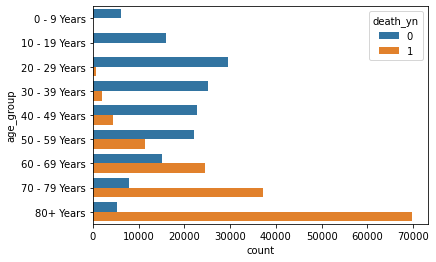

In [19]:
order_labs = ['0 - 9 Years', '10 - 19 Years', '20 - 29 Years', '30 - 39 Years', '40 - 49 Years', '50 - 59 Years',
              '60 - 69 Years', '70 - 79 Years', '80+ Years']
sns.countplot(y="age_group", hue='death_yn', data=covid_samp[covid_samp.set == "Over Sampled"], order=order_labs)

This is what our regularly sampled age group data looks like. We see that far more people survive than die in all age groups. However, our data may still be biased, since some of our death indicators were missing unkown. (We can reasonably infer that most missing and unknown data points in the death column are survivals)

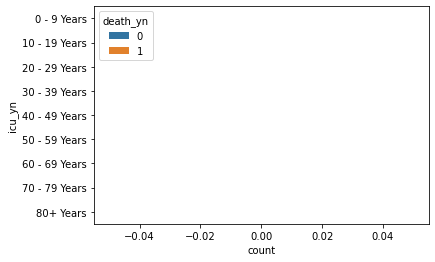

In [25]:
sns.countplot(y="age_group", hue='death_yn', data=covid_samp[covid_samp.set == "Random"], order=order_labs)

Here is a similar chart showing deaths by race. Again, this is a posterior distribution indicating the likelihood of the race, rather than if they died or not. It appears that blacks have the highest ratio of deaths versus survivals, suggesting that blacks are most at risk of death from covid-19

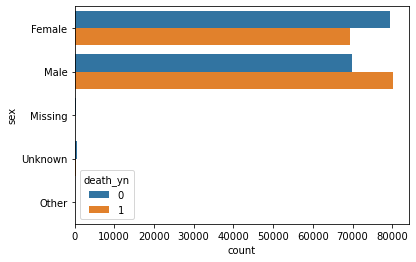

In [28]:
sns.countplot(y="Race and ethnicity (combined)", hue='death_yn', data=covid_samp[covid_samp.set == "Over Sampled"])

Here are the deaths and survivals by whether the individual had a documented underlying medical condition:

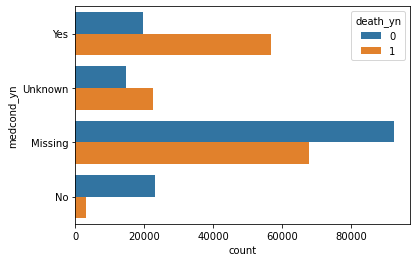

In [22]:
sns.countplot(y="medcond_yn", hue='death_yn', data=covid_samp[covid_samp.set == "Over Sampled"])

This chart shows that most of the values were missing, so we aren't sure what the true distribution should look like. However, the data do suggest that that those that die are more likely to have had a medical condition.

The next chart separates by time it takes to report. We have a lot of missing values here, but there is some indication that people who die tend to have longer period between symptom onset and cdc report date.

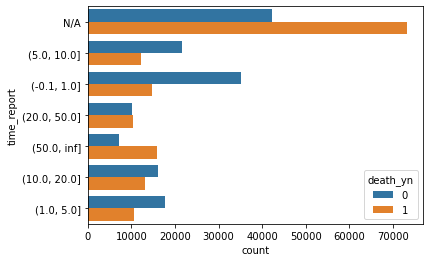

In [8]:
sns.countplot(y="time_report", hue='death_yn', data=covid_samp[covid_samp.set == "Over Sampled"])

Lastly we have deaths and survivals separated by hospitalizations. Here we see a patient who dies is way more likely to have been hospitalized than not. But it's also possible those that are hospitalized are more clearly reported in the data than those who aren't.

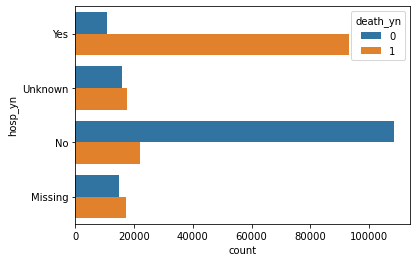

In [24]:
sns.countplot(y="hosp_yn", hue='death_yn', data=covid_samp[covid_samp.set == "Over Sampled"])

# Methods & Results

Now we will split our data back into the oversampled and random data. These become our training and testing sets. We then split into features and labels. These dataframes are what we feed into the algorithms for training. The test labels are what we compare our predictions against:

In [9]:
not_include = ['death_yn', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'set']
overSampled = covid_samp[covid_samp.set == "Over Sampled"]
randomData = covid_samp[covid_samp.set == 'Random']
X_train = pd.get_dummies(overSampled.drop(columns=not_include))
X_test = pd.get_dummies(randomData.drop(columns=not_include))
y_train = overSampled.death_yn
y_test = randomData.death_yn

Now we train several different machine learning methods. These are some of the more commonly used methods because they are very powerful and protect against overfitting. 

With each of our models we calculated the following measures:

* Precision: The ratio of correctly predicted deaths out of the total predicted deaths
* Recall: The ratio of correctly predicted deaths out of the  total actual deaths
* Accuracy: The ratio of correctly predicted deaths or survivals out of all the predictions
* Balanced Accuracy: Similar to accuracy, but weighted based on the number of actual deaths or survivals. This measure is very relevant to us because in our randomly selected data, there were far more survivals than deaths, so we want to adjust our accuracy to account for the unbalanced nature.

In [14]:
# Train each model and print out metrics
models = {'Naive Bayes': BernoulliNB(), 
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(), 
          'Gradient Boosting': GradientBoostingClassifier(),
          'Logistic Regression': LogisticRegression(),
         }
results = pd.DataFrame()
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    result = pd.Series([precision_score(y_test, preds), recall_score(y_test, preds), 
                    accuracy_score(y_test, preds), balanced_accuracy_score(y_test, preds, adjusted=True)])
    print("{} Trained".format(name))
    result.name = name
    results = results.append(result)
    
    
results.columns = ['Precision', 'Recall', 'Accuracy', 'Weighted Accuracy']
results
    

Naive Bayes Trained
Decision Tree Trained
Random Forest Trained
Gradient Boosting Trained
Logistic Regression Trained


C:\Users\barne\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Precision,Recall,Accuracy,Weighted Accuracy,w2
Naive Bayes,0.266415,0.904355,0.87888,0.781983,0.890992
Decision Tree,0.308186,0.943638,0.89814,0.839542,0.919771
Random Forest,0.305609,0.944492,0.89688,0.839032,0.919516
Gradient Boosting,0.296431,0.936379,0.89292,0.827164,0.913582
Logistic Regression,0.299629,0.929974,0.89490,0.823151,0.911575


This table shows that overall, most actual deaths are predicted (recall), but if a death is predicted, there's only about a 30% chance that the person actually died (precision). roughly 89% of the time a correct prediction is made (accuracy). But if we account for the imbalance in the data, our accuracy drops to around 80%.

Surprisingly, the model that performed best with weighted accuracy was the Decision Tree, but it was right on par with the random forest. We will continue with the decision tree because it is a much quicker and simpler model.

We will now tune the decision tree to see if we can improve the balanced accuracy. We will adjust the minimum samples per leaf parameter to be each value from 1 to 10, retrain the model, and calculate balanced accuracy.

In [42]:
cv_results = pd.DataFrame()
for i in list(range(1,11)):
    tree = DecisionTreeClassifier(min_samples_leaf=i)
    tree.fit(X_train, y_train)
    preds = tree.predict(X_test)
    result = pd.Series([i, balanced_accuracy_score(y_test, preds, adjusted=True)])
    cv_results = cv_results.append(result, ignore_index=True)
    print(result)
    
cv_results.columns = ['minimum samples per leaf', 'Balanced Accuracy']
cv_results.plot(x='minimum samples per leaf', y='Balanced Accuracy')

0    1.00000
1    0.83929
dtype: float64
0    2.000000
1    0.838813
dtype: float64
0    3.000000
1    0.836833
dtype: float64
0    4.000000
1    0.836735
dtype: float64
0    5.000000
1    0.837064
dtype: float64
0    6.00000
1    0.83572
dtype: float64
0    7.000000
1    0.836134
dtype: float64
0    8.00000
1    0.83656
dtype: float64
0    9.000000
1    0.836883
dtype: float64
0    10.000000
1     0.835322
dtype: float64


,minimum samples per leaf,Balanced Accuracy
0,1.0,0.839290
1,2.0,0.838813
2,3.0,0.836833
3,4.0,0.836735
4,5.0,0.837064
5,6.0,0.835720
6,7.0,0.836134
7,8.0,0.836560
8,9.0,0.836883
9,10.0,0.835322


It looks like a minimum sample of 1 per leaf is optimal. This is the default value.

As a last part of our analysis, we will look at feature importance. Decision trees have a convenient way of ranking the features on how they split the data, so this is a simple task.

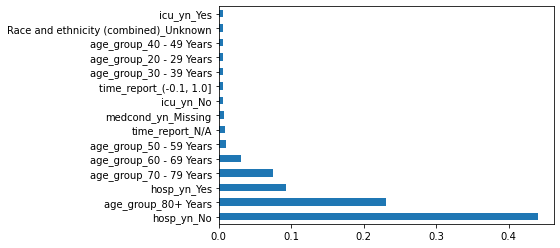

In [31]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree_feat = pd.Series(tree.feature_importances_, index = X_train.columns)
tree_feat.nlargest(15).plot(kind = 'barh')

Based on the chart above, we see that the most important feature from our training set is whether the individual was hospitalized or not. The other crucial variable is age group. All other variables probably contribute to accuracy, but have a relatively negligible effect compared to the mentioned 2 variables.

# Conclusion
From this analysis, we've looked at the CDC's data and visualized how quantity of deaths differ amongst different demographic groups. We built a model that can predict whether an individual basis. Because of the rarity of covid-deaths, our model predicted most deaths, but also predicted many people to die that would actually survive. Pragmatically, this is better than the reverse, because we would rather err on the careful side.

Limitations: There are a fair amount of limitations we can point out from the analysis. First of all, the quality of the data was subpar. There were relatively few variables to inform our model. A more accuracte medical history would've greatly improved the analysis. Secondly, there were a significant amount of missing and unknown data that contributed to the uncertainty found in the predictions. Most of the missing data was not missing at random and so that likely introduced a lot of bias to the model. On the analysis side, I could've tuned my other models to see if I could get better results with them. I also could've performed a feature selection algorithm.

Another question we might investigate further is how death rates change over time. As time goes on, we might infer that we get better at treating covid-19, and so that would affect how our model predicts. It's also reasonable that data collection changed at least slightly over time as data gathering methods became more accurate and reliable.